In [1]:
import numpy as np
import math
from random import randrange
from itertools import product, combinations
import os
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from fitter import Fitter
import ipynb_importer
import mail_auto

importing Jupyter notebook from mail_auto.ipynb


In [5]:
def second_to_hour(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    print("calc cost: %d:%02d:%02d" % (h, m, s))
    return "calc cost: %d:%02d:%02d" % (h, m, s)

def find_overlap(A, B):

    if not A.dtype == B.dtype:
        raise TypeError("Shape of A & B must be identical")
    if not A.shape[1:] == B.shape[1:]:
        raise ValueError("Apart from row dimension")

    A = np.ascontiguousarray(A.reshape(A.shape[0], -1))
    B = np.ascontiguousarray(B.reshape(B.shape[0], -1))

    t = np.dtype((np.void, A.dtype.itemsize * A.shape[1]))

    return np.in1d(A.view(t), B.view(t))

def overlap_count(A, B):
    num = len([i for i in find_overlap(A, B) if i == True])
    return num

def abs_dis(a, b, target):
    return abs(np.linalg.norm(np.array(a) - np.array(b)) - target)

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

def phi0(x):
    return 1

def phi1(x):
    return math.sqrt(3/2)*x

def phi2(x):
    return math.sqrt(2)*(3/2*(x**2) - 1)


def cpr(val1, val2):
    basis_1 = [phi0(val1), phi1(val1), phi2(val1)]
    basis_2 = [phi0(val2), phi1(val2), phi2(val2)]
    cor_func = np.sum(np.outer(basis_1, basis_2))
    return cor_func

def ideal_cor_func(cr_content, co_content, bond_num, mode='dont print bro'):
    ni_content = 1-cr_content-co_content
    
    num_crcr = cr_content**2*bond_num
    num_coco = co_content**2*bond_num
    num_nini = ni_content**2*bond_num
    num_crco = 2*cr_content*co_content*bond_num
    num_coni = 2*co_content*ni_content*bond_num
    num_crni = 2*cr_content*ni_content*bond_num
    
    cor_func = (num_crcr*cpr(0,0)
               +num_coco*cpr(1,1)
               +num_nini*cpr(-1,-1)
               +num_crco*cpr(0,1)/2
               +num_crni*cpr(0,-1)/2
               +num_coni*cpr(1,-1)/2)
    if mode == 'dont print bro':
        return cor_func
    elif mode == 'print bro':
        print(f'ideal cor func of Cr{cr_content*100}Co{co_content*100}Ni{ni_content*100}: {cor_func}')
        return cor_func

def nn_cor_func_new(cr_position, co_position, ni_position, ind, bond_dis, threshold):
    pair_list, cor_fun = [], 0
    for i1, i2 in combinations(ind, 2):
        if (abs_dis(i1, i2, bond_dis) < threshold):
            pair = np.array([i1, i2])
            len_cr_bond = overlap_count(pair, cr_position)
            len_co_bond = overlap_count(pair, co_position)
            len_ni_bond = overlap_count(pair, ni_position)

            pair_overlap = [len_cr_bond, len_co_bond, len_ni_bond]

            if pair_overlap == [2,0,0]:
                cor_func = cpr(0,0)
            elif pair_overlap == [1,1,0]:
                cor_func = cpr(0,1)/2
            elif pair_overlap == [1,0,1]:
                cor_func = cpr(0,-1)/2
            elif pair_overlap == [0,2,0]:
                cor_func = cpr(1,1)
            elif pair_overlap == [0,1,1]:
                cor_func = cpr(-1,1)/2
            elif pair_overlap == [0,0,2]:
                cor_func = cpr(-1,-1)
            
            cor_fun += cor_func
    
    return cor_fun

def nn_cor_func_inter(cr_position, co_position, ni_position, ind, bond_dis, layer_bound, threshold):
    pair_list, cor_fun = [], 0
    ind_inter = np.array([ind_i for ind_i in ind if (ind_i[2] > layer_bound[0] and ind_i[2] < layer_bound[1])])
    for i1, i2 in combinations(ind_inter, 2):
        if (abs_dis(i1, i2, bond_dis) < threshold):
            pair = np.array([i1, i2])
            len_cr_bond = overlap_count(pair, cr_position)
            len_co_bond = overlap_count(pair, co_position)
            len_ni_bond = overlap_count(pair, ni_position)

            pair_overlap = [len_cr_bond, len_co_bond, len_ni_bond]

            if pair_overlap == [2,0,0]:
                cor_func = cpr(0,0)
            elif pair_overlap == [1,1,0]:
                cor_func = cpr(0,1)/2
            elif pair_overlap == [1,0,1]:
                cor_func = cpr(0,-1)/2
            elif pair_overlap == [0,2,0]:
                cor_func = cpr(1,1)
            elif pair_overlap == [0,1,1]:
                cor_func = cpr(-1,1)/2
            elif pair_overlap == [0,0,2]:
                cor_func = cpr(-1,-1)
            
            cor_fun += cor_func
    
    return cor_fun

def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

In [2]:
def simp_struc_gen(mode = 'simp'):
    x_u = math.sqrt(2)/2
    y_u = math.sqrt(3/2)
    z_u = math.sqrt(1/3)

    layer_A1 = np.array([
        #From x to y
        [0,0,0],[0,y_u,0],[0,2*y_u,0],[0,3*y_u,0],[0,4*y_u,0],[0,5*y_u,0],
        [x_u/2,y_u/2,0],[x_u/2,3*y_u/2,0],[x_u/2,5*y_u/2,0],[x_u/2,7*y_u/2,0],[x_u/2,9*y_u/2,0],[x_u/2,11*y_u/2,0],
        [x_u,0,0],[x_u,y_u,0],[x_u,2*y_u,0],[x_u,3*y_u,0],[x_u,4*y_u,0],[x_u,5*y_u,0],
        [3*x_u/2,y_u/2,0],[3*x_u/2,3*y_u/2,0],[3*x_u/2,5*y_u/2,0],[3*x_u/2,7*y_u/2,0],[3*x_u/2,9*y_u/2,0],[3*x_u/2,11*y_u/2,0],
        [2*x_u,0,0],[2*x_u,y_u,0],[2*x_u,2*y_u,0],[2*x_u,3*y_u,0],[2*x_u,4*y_u,0],[2*x_u,5*y_u,0],
        [5*x_u/2,y_u/2,0],[5*x_u/2,3*y_u/2,0],[5*x_u/2,5*y_u/2,0],[5*x_u/2,7*y_u/2,0],[5*x_u/2,9*y_u/2,0],[5*x_u/2,11*y_u/2,0],
    ])
    layer_B1 = layer_A1 + np.array([0,1/3*y_u,z_u])
    layer_C1 = layer_B1 + np.array([0,1/3*y_u,z_u])
    for i in layer_C1:
        if i[0] == x_u/2 or i[0] == 3*x_u/2 or i[0] == 5*x_u/2:
            i[1] = i[1] - y_u

    layer_A2 = layer_A1 + np.array([0,0,3*z_u])
    layer_B2 = layer_B1 + np.array([0,0,3*z_u])
    layer_C2 = layer_C1 + np.array([0,0,3*z_u])

    layer_A3 = layer_A2 + np.array([0,0,3*z_u])
    layer_B3 = layer_B2 + np.array([0,0,3*z_u])
    layer_C3 = layer_C2 + np.array([0,0,3*z_u])

    layer_A4 = layer_A3 + np.array([0,0,3*z_u])
    layer_B4 = layer_B3 + np.array([0,0,3*z_u])
    layer_C4 = layer_C3 + np.array([0,0,3*z_u])
    if mode == 'normal':
        norm_stack = np.concatenate([layer_A1, layer_B1, layer_C1,
                                     layer_A2, layer_B2, layer_C2,
                                     layer_A3, layer_B3, layer_C3,
                                     layer_A4, layer_B4, layer_C4])
        return norm_stack
    
    if mode == 'simp':
        norm_stack_simp = np.concatenate([layer_A1, layer_B1, layer_C1,
                                          layer_A2, layer_B2, layer_C2])
        return norm_stack_simp

$[:,0]=3*\frac{\sqrt{2}}{2}$<br>
$[:,1]=6*\sqrt{\frac{3}{2}}$<br>
$[:,2]=6*\sqrt{\frac{1}{3}}$

In [3]:
def gen_crconi_sfe(cr_content, co_content, norm_pos):
    norm_raw = norm_pos.copy()
    
    norm_raw_1f, norm_raw_1s = [], []
    tuple_len = [i for i in range(len(norm_raw))]
    train_size = int(len(tuple_len)*cr_content) + randrange(2)
    co_content = co_content/(1-cr_content)
    norm_raw1, norm_raw23 = train_test_split(tuple_len, test_size = len(tuple_len) - train_size, train_size = train_size)
    train_size_sub = int(len(norm_raw23)*co_content) + randrange(2)
    norm_raw2, norm_raw3 = train_test_split(norm_raw23, test_size = len(norm_raw23) - train_size_sub, train_size = train_size_sub)
    
    cr_position = np.array([norm_raw[i] for i in norm_raw1])
    co_position = np.array([norm_raw[i] for i in norm_raw2])
    ni_position = np.array([norm_raw[i] for i in norm_raw3])
    
    ind_raw = np.concatenate([cr_position, co_position, ni_position], axis = 0)
    
    return cr_position, co_position, ni_position, ind_raw

In [5]:
norm_stack_simp = simp_struc_gen(mode = 'simp')
cr_pos, co_pos, ni_pos, ind_raw = gen_crconi_sfe(1/3, 1/3, norm_stack_simp)

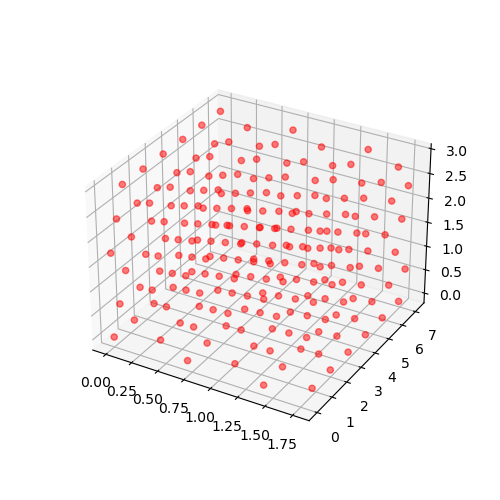

In [7]:
%matplotlib widget
draw_3d(ind_raw)

<IPython.core.display.Javascript object>


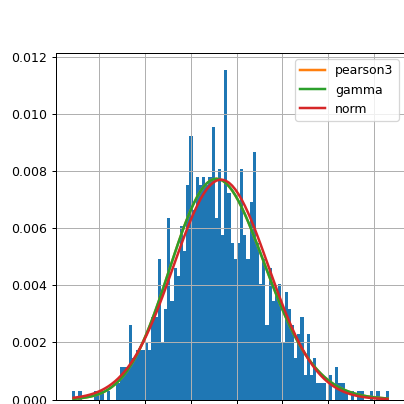

In [164]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = [5, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
# for i in test_input_stack:
#     if (i[0] == 0. or i[0] == 0.5):
#         ax.scatter(i[0], i[1], i[2], alpha=0.5, c='r')
#     elif (i[0] == 0.25 or i[0] == 0.75):
#         ax.scatter(i[0], i[1], i[2], alpha=0.5, c='k')
plt.show()

In [188]:
ind_inter = np.array([ind for ind in ind_raw if (ind[2] > 1 and ind[2] < 2)])
# ind_inter = ind_raw
count1, count2, count3, count4, count5, count6 = 0,0,0,0,0,0
for i1, i2 in combinations(ind_inter, 2):
    if abs_dis(i1,i2,0.707107) <= 0.001:
        count1 += 1
    elif abs_dis(i1,i2,1) <= 0.001:
        count2 += 1
    elif abs_dis(i1,i2,1.224745) <= 0.001:
        count3 += 1
    elif abs_dis(i1,i2,1.414214) <= 0.001:
        count4 += 1
    elif abs_dis(i1,i2,1.581139) <= 0.001:
        count5 += 1
    elif abs_dis(i1,i2,1.732051) <= 0.001:
        count6 += 1
    
print('1NN',count1)
print('2NN',count2)
print('3NN',count3)
print('4NN',count4)
print('5NN',count5)
print('6NN',count6)

1NN 251
2NN 77
3NN 256
4NN 104
5NN 102
6NN 49


In [191]:
len_list = np.load('C:/Users/yaoho/OneDrive - Kyoto University/Project/SFE/len_list_raw.npy')
print(np.unique(len_list))

[0.707107 1.       1.224745 1.414214 1.581139 1.732051 1.870829 2.
 2.12132  2.236068 2.345208 2.44949  2.54951  2.738613 2.828427 2.915476
 3.       3.082207 3.162278 3.24037  3.316625 3.391165 3.464102 3.535534
 3.605551 3.674235 3.741657 3.807887 3.937004 4.       4.062019 4.123106
 4.1833   4.242641 4.301163 4.358899 4.41588  4.472136 4.527693 4.582576
 4.636809 4.690416 4.743416 4.84768  4.898979 4.949747 5.       5.049752
 5.09902  5.147815 5.196152 5.244044 5.338539 5.385165 5.43139  5.477226
 5.522681 5.612486 5.700877 5.744563 5.787918 5.830952 5.87367  5.91608
 5.958188 6.       6.041523 6.082763 6.123724 6.164414 6.204837 6.284903
 6.324555 6.363961 6.403124 6.442049 6.519202 6.557439 6.595453 6.63325
 6.670832 6.708204 6.745369 6.78233  6.819091 6.928203 6.964194 7.
 7.035624 7.071068 7.106335 7.141428 7.17635  7.245688 7.28011  7.314369
 7.348469 7.382412 7.449832 7.516648 7.549834 7.582875 7.648529 7.713624]


In [16]:
start = time.time()
cr_content, co_content = 0.5, 0.15
cor_func_fir, cor_func_sec = [], []
cor_func_thr, cor_func_for = [], []
cor_func_fir_inter34, cor_func_sec_inter34 = [], []
cor_func_thr_inter34, cor_func_for_inter34 = [], []
cor_func_fir_inter2345, cor_func_sec_inter2345 = [], []
cor_func_thr_inter2345, cor_func_for_inter2345 = [], []
cr_pos_val, co_pos_val, ni_pos_val = [], [], []

for i in range(100):
    if i % 100 == 0:
        print(f'Step {i}')
    norm_stack_simp = simp_struc_gen(mode = 'simp')
    cr_pos, co_pos, ni_pos, ind_raw = gen_crconi_sfe(cr_content, co_content, norm_stack_simp)
    #whole sys
    cor_func_val_1 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, threshold=0.01)
    cor_func_val_2 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1, threshold=0.01)
    cor_func_val_3 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, threshold=0.01)
    cor_func_val_4 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, threshold=0.01)
    cor_func_fir.append(round(cor_func_val_1, 4))
    cor_func_sec.append(round(cor_func_val_2, 4))
    cor_func_thr.append(round(cor_func_val_3, 4))
    cor_func_for.append(round(cor_func_val_4, 4))
    #layer 2,3,4,5
    cor_func_inter2345val_1 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, [0.5, 2.5], threshold=0.01)
    cor_func_inter2345val_2 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1, [0.5, 2.5], threshold=0.01)
    cor_func_inter2345val_3 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, [0.5, 2.5], threshold=0.01)
    cor_func_inter2345val_4 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, [0.5, 2.5], threshold=0.01)
    cor_func_fir_inter2345.append(round(cor_func_inter2345val_1, 4))
    cor_func_sec_inter2345.append(round(cor_func_inter2345val_2, 4))
    cor_func_thr_inter2345.append(round(cor_func_inter2345val_3, 4))
    cor_func_for_inter2345.append(round(cor_func_inter2345val_4, 4))
    #layer 3,4
    cor_func_inter34val_1 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, [1, 2], threshold=0.01)
    cor_func_inter34val_2 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1, [1, 2], threshold=0.01)
    cor_func_inter34val_3 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, [1, 2], threshold=0.01)
    cor_func_inter34val_4 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, [1, 2], threshold=0.01)
    cor_func_fir_inter34.append(round(cor_func_inter34val_1, 4))
    cor_func_sec_inter34.append(round(cor_func_inter34val_2, 4))
    cor_func_thr_inter34.append(round(cor_func_inter34val_3, 4))
    cor_func_for_inter34.append(round(cor_func_inter34val_4, 4))

    cr_pos_val.append(cr_pos)
    co_pos_val.append(co_pos)
    ni_pos_val.append(ni_pos)
    
ideal_fir = ideal_cor_func(cr_content, co_content, 935)
ideal_sec = ideal_cor_func(cr_content, co_content, 387)
ideal_thr = ideal_cor_func(cr_content, co_content, 1394)
ideal_for = ideal_cor_func(cr_content, co_content, 621)

ideal_fir_inter2345 = ideal_cor_func(cr_content, co_content, 593)
ideal_sec_inter2345 = ideal_cor_func(cr_content, co_content, 232)
ideal_thr_inter2345 = ideal_cor_func(cr_content, co_content, 824)
ideal_for_inter2345 = ideal_cor_func(cr_content, co_content, 363)

ideal_fir_inter34 = ideal_cor_func(cr_content, co_content, 251)
ideal_sec_inter34 = ideal_cor_func(cr_content, co_content, 77)
ideal_thr_inter34 = ideal_cor_func(cr_content, co_content, 256)
ideal_for_inter34 = ideal_cor_func(cr_content, co_content, 104)

print(f'lenth of effecient struc: {len(cor_func_fir)}')
end = time.time()
cost_time = second_to_hour(end - start)
content_1 = f'SFE ROUGH Cr{int(cr_content*100)}Co{int(co_content*100)}Ni{int((1-cr_content-co_content)*100)} complete.\n'
content_2 = f'{cost_time}'
mail_auto.auto_mail(content_1+content_2)

Step 0
lenth of effecient struc: 100
calc cost: 0:04:11


In [201]:
valy_pair = np.array([i for i in cor_func_fir])
f_pair = Fitter(valy_pair, distributions = ['gamma', 'pearson3', 'norm'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best())
f_pair.summary()

{'pearson3': (0.19274657136241896, 333.0012187765292, 51.814893006086194)}


,sumsquare_error,aic,bic,kl_div
pearson3,0.000089,1353.054016,-16209.384609,inf
gamma,0.000089,1353.053652,-16209.384518,inf
norm,0.000094,1353.352419,-16162.978619,inf


In [18]:
# x = [[i, j, k, l, m, n] for i, j, k, l, m, n in zip(cor_func_fir, cor_func_sec, cor_func_thr, 
#                                         cor_func_for, cor_func_fiv, cor_func_six) if (
#     abs(i/ideal_fir - 1) <= 0.02 
#     and abs(j/ideal_sec - 1) <= 0.04
#     and abs(k/ideal_thr - 1) <= 0.04
#     and abs(l/ideal_for - 1) <= 0.04
#     and abs(m/ideal_fiv - 1) <= 0.04
#     and abs(n/ideal_six - 1) <= 0.04)]

#figuring out index of i, j
threhold1 = 0.3
threhold2 = 0.8
threhold3 = 0.8
threhold4 = 0.8
x_index = [cor_func_fir.index(i) for i, j, k, l, m, n, 
           o, p, q, r, s, t in zip(cor_func_fir, cor_func_sec, cor_func_thr, cor_func_for,
            cor_func_fir_inter2345, cor_func_sec_inter2345, cor_func_thr_inter2345, cor_func_for_inter2345,
            cor_func_fir_inter34, cor_func_sec_inter34, cor_func_thr_inter34, cor_func_for_inter34) if (
    abs(i/ideal_fir - 1) <= threhold1 
    and abs(j/ideal_sec - 1) <= threhold1
    and abs(k/ideal_thr - 1) <= threhold1
    and abs(l/ideal_for - 1) <= threhold1
    and abs(m/ideal_fir_inter2345 - 1) <= threhold3
    and abs(n/ideal_sec_inter2345 - 1) <= threhold3
    and abs(o/ideal_thr_inter2345 - 1) <= threhold3
    and abs(p/ideal_for_inter2345 - 1) <= threhold3
    and abs(q/ideal_fir_inter34 - 1) <= threhold4
    and abs(r/ideal_sec_inter34 - 1) <= threhold4
    and abs(s/ideal_thr_inter34 - 1) <= threhold4
    and abs(t/ideal_for_inter34 - 1) <= threhold4)]

x_index

[7,
 13,
 17,
 20,
 21,
 24,
 26,
 27,
 30,
 32,
 34,
 37,
 39,
 40,
 41,
 42,
 44,
 45,
 49,
 52,
 55,
 57,
 62,
 64,
 72,
 77,
 82,
 84,
 87,
 99]

In [6]:
output_list_raw = np.load(
    '/home/wz/OneDrive/Project/SFE/rawlist_cr45co15.npy',
    allow_pickle = True)
output_list_raw

array([None, None, None, None, None, None, None, None, None, None],
      dtype=object)

In [18]:
class genetic:
    def __init__(self, sample, cr_content, co_content, mode):
        self.cr_pos = sample[0]
        self.co_pos = sample[1]
        self.ni_pos = sample[2]
        self.ind = sample[3]
        
        self.ideal_fir = ideal_cor_func(cr_content, co_content, 935)
        self.ideal_sec = ideal_cor_func(cr_content, co_content, 387)
        self.ideal_thr = ideal_cor_func(cr_content, co_content, 1394)
        self.ideal_for = ideal_cor_func(cr_content, co_content, 621)

        self.ideal_fir_inter2345 = ideal_cor_func(cr_content, co_content, 593)
        self.ideal_sec_inter2345 = ideal_cor_func(cr_content, co_content, 232)
        self.ideal_thr_inter2345 = ideal_cor_func(cr_content, co_content, 824)
        self.ideal_for_inter2345 = ideal_cor_func(cr_content, co_content, 363)

        self.ideal_fir_inter34 = ideal_cor_func(cr_content, co_content, 251)
        self.ideal_sec_inter34 = ideal_cor_func(cr_content, co_content, 77)
        self.ideal_thr_inter34 = ideal_cor_func(cr_content, co_content, 256)
        self.ideal_for_inter34 = ideal_cor_func(cr_content, co_content, 104)
        
        self.mode = mode
#[cr_pos, co_pos, ni_pos, ind]
#stage1: 3&4 change; stage2: 2&5 change; stage3: 1&6change;
#stage1: eva 3&4; stage2: eva 2&3&4&5; stage3: eva Macro.
    def mutation(self, repeat_time=2):
        
        ind_raw = self.ind
        len_cr = len(self.cr_pos)
        len_co = len(self.co_pos)
        len_ni = len(self.ni_pos)
        mode = self.mode
        len_s = len(ind_raw)
        
        index_l1 = np.where(np.array(ind_raw)[:,2] == 0)[0]
        index_l2 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3))[0]
        index_l3 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*2)[0]
        index_l4 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*3)[0]
        index_l5 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*4)[0]
        index_l6 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*5)[0]
        index_l34 = np.concatenate([index_l3, index_l4])#index of 3,4 layers
        index_l25 = np.concatenate([index_l2, index_l5])#index of 2,5 layers
        index_l16 = np.concatenate([index_l1, index_l6])#index of 1,6 layers
        
        if mode=='Stage1':
            for time_ in range(repeat_time):
                point_3_ind = index_l34[np.random.randint(72)]
                point_4_ind = index_l34[np.random.randint(72)]
                point_3 = ind_raw[point_3_ind].copy()
                point_4 = ind_raw[point_4_ind].copy()
                ind_raw[point_3_ind] = point_4
                ind_raw[point_4_ind] = point_3
        
        elif mode=='Stage2':
            for time_ in range(repeat_time):
                point_5_ind = index_l25[np.random.randint(72)]
                point_6_ind = index_l25[np.random.randint(72)]
                point_5 = ind_raw[point_5_ind].copy()
                point_6 = ind_raw[point_6_ind].copy()
                ind_raw[point_5_ind] = point_6
                ind_raw[point_6_ind] = point_5
                
        elif mode=='Stage3':
            for time_ in range(repeat_time):
                point_a_ind = index_l16[np.random.randint(72)]
                point_b_ind = index_l16[np.random.randint(72)]
                point_a = ind_raw[point_a_ind].copy()
                point_b = ind_raw[point_b_ind].copy()
                ind_raw[point_a_ind] = point_b
                ind_raw[point_b_ind] = point_a
        
        elif mode=='Whole':
            for time_ in range(repeat_time):
                point_7_ind = np.random.randint(len_s)
                point_8_ind = np.random.randint(len_s)
                point_7 = ind_raw[point_7_ind].copy()
                point_8 = ind_raw[point_8_ind].copy()
                ind_raw[point_7_ind] = point_8
                ind_raw[point_8_ind] = point_7
                
        cr_pos_mut = ind_raw[0:len_cr]
        co_pos_mut = ind_raw[len_cr:len_cr+len_co]
        ni_pos_mut = ind_raw[len_cr+len_co:len_cr+len_co+len_ni]
        mut_gen = [cr_pos_mut, co_pos_mut, ni_pos_mut, ind_raw]
        return mut_gen
    
    def fitness(self):
        mode = self.mode
        cr_pos = np.array(self.cr_pos)
        co_pos = np.array(self.co_pos)
        ni_pos = np.array(self.ni_pos)
        ind_raw = np.concatenate([cr_pos, co_pos, ni_pos], axis = 0)
        
        ideal_fir = self.ideal_fir
        ideal_sec = self.ideal_sec
        ideal_thr = self.ideal_thr
        ideal_for = self.ideal_for

        ideal_fir_inter2345 = self.ideal_fir_inter2345
        ideal_sec_inter2345 = self.ideal_sec_inter2345
        ideal_thr_inter2345 = self.ideal_thr_inter2345
        ideal_for_inter2345 = self.ideal_for_inter2345

        ideal_fir_inter34 = self.ideal_fir_inter34
        ideal_sec_inter34 = self.ideal_sec_inter34
        ideal_thr_inter34 = self.ideal_thr_inter34
        ideal_for_inter34 = self.ideal_for_inter34

        #whole sys
        cor_func_val_1 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, threshold=0.01)
        cor_func_val_2 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1, threshold=0.01)
        cor_func_val_3 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, threshold=0.01)
        cor_func_val_4 = nn_cor_func_new(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, threshold=0.01)

        res_1 = abs(ideal_fir - cor_func_val_1)
        res_2 = abs(ideal_sec - cor_func_val_2)
        res_3 = abs(ideal_thr - cor_func_val_3)
        res_4 = abs(ideal_for - cor_func_val_4)
        res_1_ratio = res_1/ideal_fir
        res_2_ratio = res_2/ideal_sec
        res_3_ratio = res_3/ideal_thr
        res_4_ratio = res_4/ideal_for

        #layer 2,3,4,5
        cor_func_inter2345val_1 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, [0.5, 2.5], threshold=0.01)
        cor_func_inter2345val_2 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1, [0.5, 2.5], threshold=0.01)
        cor_func_inter2345val_3 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, [0.5, 2.5], threshold=0.01)
        cor_func_inter2345val_4 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, [0.5, 2.5], threshold=0.01)
    
        res_1_in2345 = abs(ideal_fir_inter2345 - cor_func_inter2345val_1)
        res_2_in2345 = abs(ideal_sec_inter2345 - cor_func_inter2345val_2)
        res_3_in2345 = abs(ideal_thr_inter2345 - cor_func_inter2345val_3)
        res_4_in2345 = abs(ideal_for_inter2345 - cor_func_inter2345val_4)
        res_1_in2345_ratio = res_1_in2345/ideal_fir_inter2345
        res_2_in2345_ratio = res_2_in2345/ideal_sec_inter2345
        res_3_in2345_ratio = res_3_in2345/ideal_thr_inter2345
        res_4_in2345_ratio = res_4_in2345/ideal_for_inter2345

        #layer 3,4
        cor_func_inter34val_1 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 0.707107, [1, 2], threshold=0.01)
        cor_func_inter34val_2 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1, [1, 2], threshold=0.01)
        cor_func_inter34val_3 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.224745, [1, 2], threshold=0.01)
        cor_func_inter34val_4 = nn_cor_func_inter(cr_pos, co_pos, ni_pos, ind_raw, 1.414214, [1, 2], threshold=0.01)
    
        res_1_in34 = abs(ideal_fir_inter34 - cor_func_inter34val_1)
        res_2_in34 = abs(ideal_sec_inter34 - cor_func_inter34val_2)
        res_3_in34 = abs(ideal_thr_inter34 - cor_func_inter34val_3)
        res_4_in34 = abs(ideal_for_inter34 - cor_func_inter34val_4)
        res_1_in34_ratio = res_1_in34/ideal_fir_inter34
        res_2_in34_ratio = res_2_in34/ideal_sec_inter34
        res_3_in34_ratio = res_3_in34/ideal_thr_inter34
        res_4_in34_ratio = res_4_in34/ideal_for_inter34

        if mode=='Stage1':
            p_whole = 1
            p_2345 = 4
            p_34 = 10
        elif mode=='Stage2':
            p_whole = 1
            p_2345 = 5
            p_34 = 0
        elif mode=='Stage3':
            p_whole = 1
            p_2345 = 0
            p_34 = 0
        elif mode=='Whole':
            p_whole = 1
            p_2345 = 2
            p_34 = 6
            
        fitness = np.linalg.norm([res_1*p_whole,res_2*p_whole,res_3*p_whole,res_4*p_whole,
                                  res_1_in2345*p_2345,res_2_in2345*p_2345,
                                  res_3_in2345*p_2345,res_4_in2345*p_2345,
                                  res_1_in34*p_34,res_2_in34*p_34,res_3_in34*p_34,res_4_in34*p_34])
        
        fitness_ratio = np.array([res_1_ratio,res_2_ratio,res_3_ratio,res_4_ratio,
                                  res_1_in2345_ratio,res_2_in2345_ratio,res_3_in2345_ratio,res_4_in2345_ratio,
                                  res_1_in34_ratio,res_2_in34_ratio,res_3_in34_ratio,res_4_in34_ratio])
        
        fitness_part_ratio = np.array([np.mean(fitness_ratio[0:4]),np.mean(fitness_ratio[4:8]),np.mean(fitness_ratio[8:12])])
        fitness_ratio_34 = np.array([res_1_in34_ratio,res_2_in34_ratio,res_3_in34_ratio,res_4_in34_ratio])

        return fitness, np.mean(fitness_ratio), fitness_part_ratio, fitness_ratio_34, np.max(fitness_ratio)

def stack_trans(input_coor):
    input_coor = np.array(input_coor)
    # when normal condition
    for i in input_coor:
        if i[2] > 1.5:
            i[1] -= 2/3*math.sqrt(3/2)
            if i[1] < 0:
                i[1] = 6*math.sqrt(3/2) - i[1]
                
    return input_coor

In [20]:
origin_list =  []
for i in range(10):
    index_chosen = x_index[i]
    cr_chosen = cr_pos_val[index_chosen].tolist()
    co_chosen = co_pos_val[index_chosen].tolist()
    ni_chosen = ni_pos_val[index_chosen].tolist()
    ind = np.concatenate([cr_chosen, co_chosen, ni_chosen], axis = 0).tolist()
    origin_list.append([cr_chosen, co_chosen, ni_chosen, ind])

np.save(f'origin_list{int(cr_content*100)}{int(co_content*100)}', origin_list)

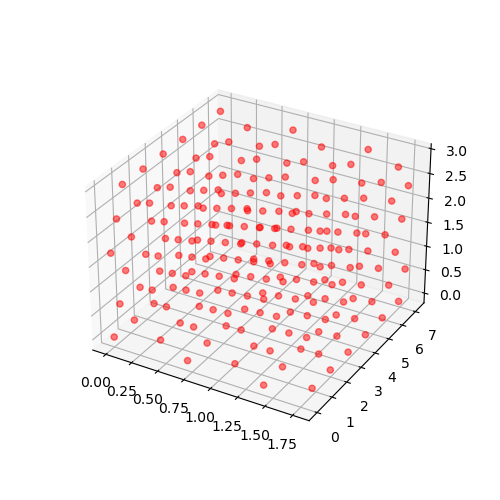

In [16]:
%matplotlib widget
draw_3d(origin_list[0][3])

In [19]:
print(cr_content, co_content)

0.5 0.15


In [19]:
# 采用随机选取fitness的形式，ratio/fitness - inf norm.
plot_fit, fitness, len_fitlist = [], [], []
fitness_2345, fitness_34 = [], []
fitness_mean, fitness_whole, fitness_maxratio = [], [], []
for i1 in range(len(origin_list)):
    gen1 = genetic(origin_list[i1], cr_content, co_content, 'Stage3')
    fit1 = gen1.fitness()[0]
    fit_max = gen1.fitness()[-1]
    gen1_2345 = genetic(origin_list[i1], cr_content, co_content, 'Stage2')
    fit1_2345 = gen1_2345.fitness()[0]
    gen1_34 = genetic(origin_list[i1], cr_content, co_content, 'Stage1')
    fit1_34 = gen1_34.fitness()[0]
    gen_whole = genetic(origin_list[i1], cr_content, co_content, 'Whole')
    fit_whole = gen_whole.fitness()[0]

    fitness.append(fit1)
    fitness_2345.append(fit1_2345)
    fitness_34.append(fit1_34)
    fitness_whole.append(fit_whole)
    fitness_maxratio.append(fit_max)

## concat two fitness list and randomly choose at judgement, when doing
## whole mutation!
start = time.time()
kkt = 0
try_step = 500
for kkt in range(try_step):
    len_fit = len(fitness_whole)
    fitness_mean.append(np.mean(fitness_whole))
    plot_fit.append(np.min(fitness_whole))
    prob_list = np.array([(1/(fitness_whole[i3]/np.sum(fitness_whole)))**4 for i3 in range(len(fitness_whole))])
    prob_list = (1-prob_list)/np.sum(1-prob_list)
    prob_list_neo = np.zeros(len(prob_list))
    #进行筛选时也考虑层间权重
    for i4 in range(len(prob_list)):
        prob_list_neo[i4] = np.sum(prob_list[:i4+1])

#     trials = 30
    second_list = []    
    god_dice = np.random.rand()
    prob_sign = np.sign(god_dice - prob_list_neo)
    god_chosen_ind = np.where(prob_sign == -1)[0][0]#the chosen index
    god_chose = origin_list[god_chosen_ind]
    
    if kkt < int(try_step/4):
        gen1 = genetic(god_chose, cr_content, co_content, mode='Stage1')
        gen1_whole = genetic(god_chose, cr_content, co_content, mode='Whole')

        for repeat_time in range(1, 5):
            mut1 = gen1.mutation(repeat_time)
            gen_mut = genetic(mut1, cr_content, co_content, mode='Stage1')
            gen_mut_whole = genetic(mut1, cr_content, co_content, mode='Whole')
            fit2 = gen_mut.fitness()[0]
            fit2_whole = gen_mut_whole.fitness()[0]

            if (fit2 < np.mean(fitness_34)
                and np.linalg.norm(np.array(mut1[3])-np.array(origin_list[-1][3])) > 0):
                mut1_k = mut1.copy()
                origin_list.append(mut1_k)
                fitness_34.append(fit2)#34
                fitness_whole.append(fit2_whole)
                gen2_whole = genetic(mut1_k, cr_content, co_content, mode='Whole')
                mut2 = gen2_whole.mutation(repeat_time)
                mut2_whole = genetic(mut2, cr_content, co_content, mode='Whole')
                fit3 = mut2_whole.fitness()[0]
                mut2_34 = genetic(mut2, cr_content, co_content, mode='Stage1')
                fit3_34 = mut2_34.fitness()[0]
                if (fit3 <= np.mean(fitness_whole)
                    and fit3_34 <= np.mean(fitness_34)):

                    fitness_whole.append(fit3)
                    origin_list.append(mut2)
                    fitness_34.append(fit3_34)#34
            
    elif int(try_step/4) <= kkt < int(5/8*try_step):
        gen1 = genetic(god_chose, cr_content, co_content, mode='Stage2')

        for repeat_time in range(1, 6):
            mut1 = gen1.mutation(repeat_time)
            gen_mut = genetic(mut1, cr_content, co_content, mode='Stage2')
            gen_mut_whole = genetic(mut1, cr_content, co_content, mode='Whole')
            fit2 = gen_mut.fitness()[0]
            fit2_whole = gen_mut_whole.fitness()[0]

            if (fit2 < np.mean(fitness_2345)#stage 2
                and np.linalg.norm(np.array(mut1[3])-np.array(origin_list[-1][3])) > 0):
                mut1_k = mut1.copy()
                origin_list.append(mut1_k)
                gen_mut_34 = genetic(mut1_k, cr_content, co_content, mode='Stage1')
                fit2_34 = gen_mut_34.fitness()[0]
                fitness_34.append(fit2_34)#34
                fitness_2345.append(fit2)
                fitness_whole.append(fit2_whole)
                gen2_whole = genetic(mut1_k, cr_content, co_content, mode='Whole')
                mut2 = gen2_whole.mutation(repeat_time)
                mut2_whole = genetic(mut2, cr_content, co_content, mode='Whole')
                fit3 = mut2_whole.fitness()[0]
                mut2_34 = genetic(mut2, cr_content, co_content, mode='Stage1')
                fit3_34 = mut2_34.fitness()[0]
                if (fit3 <= np.mean(fitness_whole)
                    and fit3_34 <= np.mean(fitness_34)
                    and np.linalg.norm(np.array(mut2[3])-np.array(origin_list[-1][3])) > 0):

                    fitness_whole.append(fit3)
                    origin_list.append(mut2)
                    fitness_34.append(fit3_34)#34
                
    elif int(5/8*try_step) <= kkt:
        gen1 = genetic(god_chose, cr_content, co_content, mode='Stage3')

        for repeat_time in range(1, 6):
            mut1 = gen1.mutation(repeat_time)
            gen_mut = genetic(mut1, cr_content, co_content, mode='Stage3')
            gen_mut_whole = genetic(mut1, cr_content, co_content, mode='Whole')
            fit2 = gen_mut.fitness()[0]
            fit2_whole = gen_mut_whole.fitness()[0]

            if (fit2 < np.mean(fitness)
                and np.linalg.norm(np.array(mut1[3])-np.array(origin_list[-1][3])) > 0):
                mut1_k = mut1.copy()
                gen_mut_34 = genetic(mut1_k, cr_content, co_content, mode='Stage1')
                fit2_34 = gen_mut_34.fitness()[0]
                fitness_34.append(fit2_34)#34
                origin_list.append(mut1_k)
                fitness.append(fit2)
                fitness_whole.append(fit2_whole)
                gen2_whole = genetic(mut1_k, cr_content, co_content, mode='Whole')
                mut2 = gen2_whole.mutation(repeat_time)
                mut2_whole = genetic(mut2, cr_content, co_content, mode='Whole')
                fit3 = mut2_whole.fitness()[0]
                mut2_34 = genetic(mut2, cr_content, co_content, mode='Stage1')
                fit3_34 = mut2_34.fitness()[0]

                if (fit3 <= np.mean(fitness_whole)
                    and fit3_34 <= np.mean(fitness_34)
                    and np.linalg.norm(np.array(mut2[3])-np.array(origin_list[-1][3])) > 0):
                    
                    fitness_whole.append(fit3)
                    origin_list.append(mut2)
                    fitness_34.append(fit3_34)#34
            
    if len(fitness) >= 200:
        new_type = []
        new_type_ind = np.where(fitness_34 <= np.mean(fitness_34))[0]
#选择interface层进行筛选
        if len(new_type_ind) >= 10:
            for nt in new_type_ind:
                new_type.append(origin_list[nt])
            origin_list = new_type.copy()
            fitness, fitness_2345, fitness_34, fitness_whole = [], [], [], []

            for ifit in range(len(origin_list)):
                gen1 = genetic(origin_list[ifit], cr_content, co_content, 'Stage3')
                fit1 = gen1.fitness()[0]
                gen1_2345 = genetic(origin_list[ifit], cr_content, co_content, 'Stage2')
                fit1_2345 = gen1_2345.fitness()[0]
                gen1_34 = genetic(origin_list[ifit], cr_content, co_content, 'Stage1')
                fit1_34 = gen1_34.fitness()[0]
                gen1_whole = genetic(origin_list[ifit], cr_content, co_content, 'Whole')
                fit1_whole = gen1_whole.fitness()[0]
                fitness.append(fit1)
                fitness_2345.append(fit1_2345)
                fitness_34.append(fit1_34)
                fitness_whole.append(fit1_whole)

    if kkt % 100 == 0:
        len_fitlist.append(len(fitness_whole))
        
    min_fitness = np.min(fitness_whole)
    if kkt % 100 == 0:
        print(f'Step {kkt}, with MIN fitness {min_fitness}, with MEAN fitness {np.mean(fitness_whole)}')
    
plt.plot(plot_fit)
end = time.time()
second_to_hour(end - start)
content_1 = f'SFE <Genetic> Cr{int(cr_content*100)}Co{int(co_content*100)}Ni{int((1-cr_content-co_content)*100)} complete.\n'
content_2 = f'{second_to_hour(end-start)}'
mail_auto.auto_mail(content_1+content_2)

Step 0, with MIN fitness 197.26204732230227, with MEAN fitness 315.7210928811532
Step 100, with MIN fitness 157.25938988188207, with MEAN fitness 231.99679072570575
Step 200, with MIN fitness 115.29184499859694, with MEAN fitness 287.16675268800907
Step 300, with MIN fitness 115.29184499859694, with MEAN fitness 304.25676270618175
Step 400, with MIN fitness 115.29184499859694, with MEAN fitness 303.944515691962


TypeError: plot() missing 1 required positional argument: 'ys'

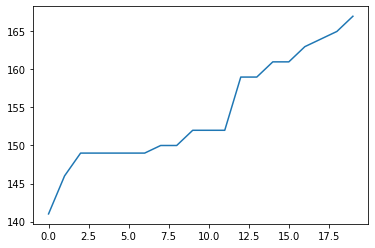

In [31]:
plt.plot(len_fitlist)

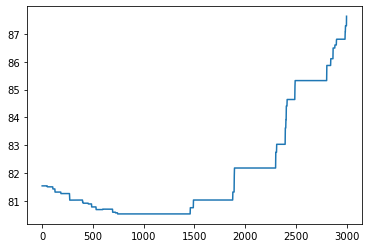

In [45]:
plt.plot(fitness_mean)

In [28]:
ind_best = np.where(fitness_whole <= np.min(fitness_whole)+60)[0]
ind_best

array([20, 21, 31, 32, 49, 56, 60, 61, 62, 63])

In [32]:
fit_ratio = []
for i in ind_best:
    gen1 = genetic(origin_list[i], cr_content, co_content, 'Whole')
    fit_ratio.append(gen1.fitness()[2])
    
fit_ratio

[array([0.07154811, 0.08132495, 0.20618779]),
 array([0.0732815 , 0.08135401, 0.20618779]),
 array([0.12995522, 0.17214078, 0.09294393]),
 array([0.12738386, 0.15934016, 0.09104183]),
 array([0.0777023 , 0.1401004 , 0.10030158]),
 array([0.08503217, 0.10803016, 0.11835949]),
 array([0.12352832, 0.1417698 , 0.11186731]),
 array([0.05625867, 0.10609966, 0.17136727]),
 array([0.05903943, 0.14421539, 0.06643119]),
 array([0.05908042, 0.14684383, 0.06643119])]

In [31]:
print(cr_content, co_content)

0.4 0.2


In [27]:
len_index = len(ind_best)
start_index = 10
name_raw = 'Cr45Co20Ni35_SFE'
name_stack = 'Cr45Co20Ni35_SFE_stack'

$[:,0]=3*\frac{\sqrt{2}}{2}$<br>
$[:,1]=6*\sqrt{\frac{3}{2}}$<br>
$[:,2]=6*\sqrt{\frac{1}{3}}$

In [48]:
def norm_trans(input_array):
    input_array = np.array(input_array)
    return input_array/np.array([3*math.sqrt(1/2), 6*math.sqrt(3/2), 6*math.sqrt(1/3)])

def stack_trans(input_coor):
    input_coor = np.array(input_coor)
    # when normal condition
    for i in input_coor:
        if i[2] > 1.5:
            i[1] -= 2/3*math.sqrt(3/2)
            if i[1] < 0:
                i[1] = 6*math.sqrt(3/2) + i[1]
                
    return input_coor

def back_to_raw(input_array):
    return input_array/np.array([
        3*math.sqrt(2)/2, 6*math.sqrt(3/2), 6*math.sqrt(1/3)])

In [32]:
for i in range(len_index):
    trial = start_index+i
    create_dir(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_raw}_try{trial}')
    create_dir(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_stack}_try{trial}')
    
    cr_pos_chosen = np.array(origin_list[i][0])
    cr_pos_stack = stack_trans(cr_pos_chosen)
    cr_pos_chosen = norm_trans(cr_pos_chosen)
    cr_pos_stack = norm_trans(cr_pos_stack)
    for i_cr in range(len(cr_pos_chosen)):
        cr_pos_chosen[i_cr][2] = 1/2*cr_pos_chosen[i_cr][2]
        cr_pos_stack[i_cr][2] = 1/2*cr_pos_stack[i_cr][2]
        
    co_pos_chosen = np.array(origin_list[i][1])
    co_pos_stack = stack_trans(co_pos_chosen)
    co_pos_chosen = norm_trans(co_pos_chosen)
    co_pos_stack = norm_trans(co_pos_stack)
    for i_co in range(len(co_pos_chosen)):
        co_pos_chosen[i_co][2] = 1/2*co_pos_chosen[i_co][2]
        co_pos_stack[i_co][2] = 1/2*co_pos_stack[i_co][2]
        
    ni_pos_chosen = np.array(origin_list[i][2])
    ni_pos_stack = stack_trans(ni_pos_chosen)
    ni_pos_chosen = norm_trans(ni_pos_chosen)
    ni_pos_stack = norm_trans(ni_pos_stack)
    for i_ni in range(len(ni_pos_chosen)): 
        ni_pos_chosen[i_ni][2] = 1/2*ni_pos_chosen[i_ni][2]
        ni_pos_stack[i_ni][2] = 1/2*ni_pos_stack[i_ni][2]
    
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_raw}_try{trial}/{name_raw}_cr_chosen.npy', 
            cr_pos_chosen)
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_raw}_try{trial}/{name_raw}_co_chosen.npy', 
            co_pos_chosen)
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_raw}_try{trial}/{name_raw}_ni_chosen.npy', 
            ni_pos_chosen)
    
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_stack}_try{trial}/{name_stack}_cr_stackchosen.npy', 
            cr_pos_stack)
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_stack}_try{trial}/{name_stack}_co_stackchosen.npy', 
            co_pos_stack)
    np.save(f'G:/マイドライブ/MSAD/CONFIG/multi_cor/{name_stack}_try{trial}/{name_stack}_ni_stackchosen.npy', 
            ni_pos_stack)
    
    ind_stack = np.concatenate([cr_pos_stack, co_pos_stack, ni_pos_stack], axis = 0)
    ind_raw = np.concatenate([cr_pos_chosen, co_pos_chosen, ni_pos_chosen], axis = 0)

Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try10
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try10
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try11
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try11
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try12
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try12
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try13
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try13
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try14
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try14
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try15
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try15
Created Directory :  G:/マイドライブ/MSAD/CONFIG/multi_cor

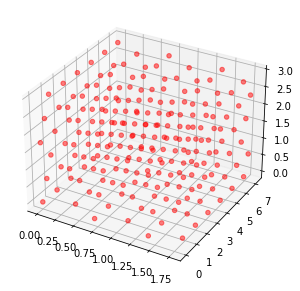

In [29]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [5, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
plt.show()

In [30]:
ind_raw_cr = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try10/Cr45Co20Ni35_SFE_cr_chosen.npy')
ind_raw_co = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try10/Cr45Co20Ni35_SFE_co_chosen.npy')
ind_raw_ni = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try10/Cr45Co20Ni35_SFE_ni_chosen.npy')
ind_stack_cr = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try10/Cr45Co20Ni35_SFE_stack_cr_stackchosen.npy')
ind_stack_co = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try10/Cr45Co20Ni35_SFE_stack_co_stackchosen.npy')
ind_stack_ni = np.load('G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_stack_try10/Cr45Co20Ni35_SFE_stack_ni_stackchosen.npy')

ind_raw = np.concatenate([ind_raw_cr, ind_raw_co, ind_raw_ni], axis= 0)
ind_stack = np.concatenate([ind_stack_cr, ind_stack_co, ind_stack_ni], axis= 0)

FileNotFoundError: [Errno 2] No such file or directory: 'G:/マイドライブ/MSAD/CONFIG/multi_cor/Cr45Co20Ni35_SFE_try10/Cr45Co20Ni35_SFE_cr_chosen.npy'

In [21]:
index_l1 = np.where(np.array(ind_raw)[:,2] == 0)[0]
index_l2 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3))[0]
index_l3 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*2)[0]
index_l4 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*3)[0]
index_l5 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*4)[0]
index_l6 = np.where(np.array(ind_raw)[:,2] == math.sqrt(1/3)*5)[0]
index_l34 = np.concatenate([index_l3, index_l4])#index of 3,4 layers
index_l25 = np.concatenate([index_l2, index_l5])#index of 2,5 layers
index_l16 = np.concatenate([index_l1, index_l6])#index of 1,6 layers

In [25]:
norm_stack_simp = simp_struc_gen(mode = 'simp')
cr_pos, co_pos, ni_pos, ind_raw = gen_crconi_sfe(1/3, 1/3, norm_stack_simp)
